In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
import preprocess
import billinfo

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Functions

In [11]:
"""
method to load the data
congressman: location of the congressman csv
large: whether to use the bert large(True) or distilbert(False) embeddings

"""
def load_data(congressman, large, degree, random_state=42, test_size = 0.2):
    voting_record = pd.read_csv(congressman)
    if not large:
        bill_data = pd.read_csv('distilbert_final_csv.csv')
        finalized_data, cosponsor_categories, committee_categories, subject_categories = preprocess.get_finished_df(voting_record, bill_data)
    else:
        bill_data = pd.read_json('bert_large_final_json.json')
        finalized_data, cosponsor_categories, committee_categories, subject_categories = preprocess.get_finished_df_large(voting_record, bill_data)

    #turn the combined column(which is an array in each row) into a bunch of features
    X = pd.DataFrame(finalized_data['combined'].tolist(), columns=[f'x{i}' for i in range(finalized_data['combined'].iloc[0].size)])
    preprocess.polynomial_features(X, degree=degree)
    y = finalized_data['vote']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return finalized_data, cosponsor_categories, committee_categories, subject_categories, X, y, X_train, X_test, y_train, y_test


#Method to create the neural netwoek, Recall yields the best results
def create_neural_network(X_train, X_test, y_train, y_test, epochs = 20, metric = ['Recall']):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(8192, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(4096, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2048, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1024, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(512, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation='relu'),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metric)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)

    train_loss, train_recall = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_recall = model.evaluate(X_test, y_test, verbose=0)

    print(f'Train Loss: {train_loss}, Train Recall: {train_recall}')
    print(f'Test Loss: {test_loss}, Test Recall: {test_recall}')

    # Predictions
    y_train_pred_prob = model.predict(X_train)
    y_test_pred_prob = model.predict(X_test)

    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)

    report = classification_report(y_test, y_test_pred, target_names=['Yea', 'Nay'])
    print(report)

    save_dir = 'Trained'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model.save(os.path.join(save_dir, 'Scott_Peters_CA_Democrat_rep_P000608_2.keras'))

    return model, history, y_train_pred, y_test_pred


#method to train the neural network model
def train_neural_network(congressman, large, epochs=15, metric=['Recall'], degree=1):
    finalized_data, cosponsor_categories, committee_categories, subject_categories, X, y, X_train, X_test, y_train, y_test = load_data(congressman, large, degree=degree)
    model, history, y_train_pred, y_val_pred, y_test_pred = create_neural_network(X_train, X_test, y_train, y_test, epochs=epochs, metric=metric)

    print("\nExample Ground Truth and Predictions:")
    print("\nTraining Set:")
    for i in range(5):
        print(f"Ground Truth: {y_train.iloc[i]}, Prediction: {y_train_pred[i][0]}")

    print("\nValidation Set:")
    for i in range(5):
        print(f"Ground Truth: {y_val.iloc[i]}, Prediction: {y_val_pred[i][0]}")

    print("\nTest Set:")
    for i in range(5):
        print(f"Ground Truth: {y_test.iloc[i]}, Prediction: {y_test_pred[i][0]}")

    return model, history

#method to train the logistic_regression model
def train_logistic_regression(congressman, large, max_iter = 50, degree=1):
    finalized_data, cosponsor_categories, committee_categories, subject_categories, X, y, X_train, X_test, y_train, y_test = load_data(congressman, large, degree=degree)
    model = create_logistic_regression(X_train, X_test, y_train, y_test, max_iter)
    return model

#method to load a model from memory
def load_model(location):
    return tf.keras.models.load_model(location)


#function to get a bills info and provide a prediction
def predict(congress, bill_type, bill_number, model, congressman, large):
    bill = billinfo.get_bill_as_df(congress, bill_type, bill_number, congressman, large)

    predicted = model.predict(bill)
    #logistic regression returns a 1d array, neural network returns a 2d array, so this try except needs to be done to get the info
    try:
        if predicted[0,0] < 0.5:
            print(F"Prediction: Yea \n Probability of Yea: {(1-predicted[0,0])*100}% \n Probability of Nay: {predicted[0,0]*100}%")
        else:
            print(F"Prediction: Nay \n Probability of Yea: {(1-predicted[0,0])*100}% \n Probability of Nay: {predicted[0,0]*100}%")
    except:
        if predicted[0] < 0.5:
            print("Prediction: Yea")
        else:
            print("Prediction: Nay")

## Neural Model

### Training the Model

In [ ]:
#Select your congressman
congressman = 'congressman_votes_data/Scott_Peters_CA_Democrat_rep_P000608_nan.csv'

#Bert large (True) or distilbert (False)
large = False

print("Neural Network: ")
neural_model, history = train_neural_network(congressman, large=large, epochs=10, metric=['Recall'])

predict(118, 's', 1667, neural_model, congressman, large=large)
predict(118, 'hr', 3442, neural_model, congressman, large=large)

Neural Network: 
Epoch 1/10
45/45 [==============================] - 121s 3s/step - loss: 0.5115 - Recall: 0.0871 - val_loss: 0.2831 - val_Recall: 0.0174
Epoch 2/10
45/45 [==============================] - 131s 3s/step - loss: 0.2700 - Recall: 0.1202 - val_loss: 0.3955 - val_Recall: 0.2469
Epoch 3/10
45/45 [==============================] - 90s 2s/step - loss: 0.2714 - Recall: 0.3327 - val_loss: 0.2500 - val_Recall: 0.3805
Epoch 4/10
45/45 [==============================] - 115s 3s/step - loss: 0.1670 - Recall: 0.4264 - val_loss: 0.3455 - val_Recall: 0.4617
Epoch 5/10
45/45 [==============================] - 128s 3s/step - loss: 0.1397 - Recall: 0.4943 - val_loss: 0.3863 - val_Recall: 0.5232
Epoch 6/10
45/45 [==============================] - 95s 2s/step - loss: 0.1350 - Recall: 0.5407 - val_loss: 0.5686 - val_Recall: 0.5682
Epoch 7/10
45/45 [==============================] - 104s 2s/step - loss: 0.1822 - Recall: 0.5866 - val_loss: 0.2904 - val_Recall: 0.6070
Epoch 8/10
45/45 [========

### Plotting the fitting curve

NameError: name 'history' is not defined

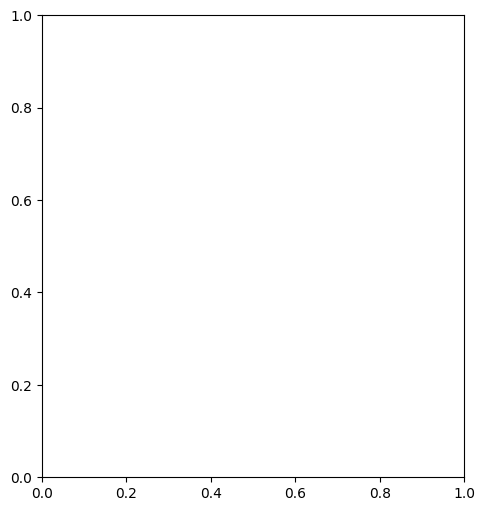

In [3]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['Recall'], label = 'Training Recall')
plt.plot(history.history['val_Recall'], label = 'Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

### Other Results

The train and test loss and recall are as follows:

| | Loss | Recall
| --- | --- | ---
| Train | 0.117 | 0.705
| Test | 0.302 | 0.716

From the classification report we can also see that for the test data, the precision, recall, F1 score for the two classes are:

| | Precision | Recall | F1
| --- | --- | --- | ---
| Yea | 0.96 | 0.93 | 0.95
| Nay | 0.66 | 0.80 | 0.73